# TD3

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

In [3]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import pickle
import gc
import json
import h5py

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline


# == recnn ==
import sys
sys.path.append("../../")
import recnn

cuda = torch.device('cuda')
# ---
frame_size = 10
batch_size = 25
# --- 

tqdm.pandas()

In [5]:
# https://drive.google.com/open?id=1kTyu05ZmtP2MA33J5hWdX8OyUYEDW4iI
movie_ref = pickle.load(open('../../data/infos_pca128.pytorch', 'rb'))
movie_ref_tensor, key_to_id, id_to_key = recnn.data.make_movie_tensor(movie_ref)
# download ml20m dataset
ratings = pd.read_csv('../../data/ml-20m/ratings.csv')
user_dict, users = recnn.data.prepare_tensor(ratings, key_to_id, frame_size)
del ratings
gc.collect()
clear_output(True)
clear_output(True)
print('Done!')

Done!


In [9]:
def soft_update(net, target_net, soft_tau=1e-2):
    for target_param, param in zip(target_net.parameters(), net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

In [21]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy import ndimage
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style(theme='grade3')

def run_tests():
    test_batch = next(iter(test_dataloader))
    losses = td3_update(-1, test_batch, params, learn=False)
    return losses

# value, policy, step
def plot_losses(value_losses1, value2_losses, policy_losses, test=True, smoothing=4):
    global test_losses
    if test:
        test_ = run_tests()
        test_losses[0].append(test_[0])
        test_losses[1].append(test_[1])
        test_losses[2].append(test_[2])
        test_losses[3].append(len(value1_losses))
        
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('value')
    # you can change it to weighted smoothing
    plt.plot(recnn.plot.smooth_gauss(value1_losses, smoothing), label='1 tr')
    #plt.plot(moving_average(value2_losses), label='2 tr')
    plt.plot(test_losses[3], test_losses[0], label='1 te')
    # plt.plot(test_losses[3], test_losses[1], label='2 te')
    plt.legend()
    plt.subplot(132)
    plt.title('policy')
    plt.plot(recnn.plot.smooth_gauss(policy_losses, smoothing), label='train')
    plt.plot(test_losses[3], test_losses[2], '-r', label='test')
    plt.legend()
    plt.show()

In [23]:
def debug_log_error(name, x):
    global debug_dict
    try:
        target = debug_dict['error'][name] 
    except KeyError:
        if name not in debug_dict['error']:
            debug_dict['error'][name] = {}
            target = debug_dict['error'][name] 
            target['std'] = []
            target['mean'] = []
    
    target['std'].append(x.std().item())
    target['mean'].append(x.mean().item())
    

def debug_log_object(name, x):
    global debug_dict
    debug_dict['obj'][name] = x

def td3_update(step, batch, params, learn=True):
    
    batch = [i.to(cuda) for i in batch]
    state, action, reward, next_state, done = batch
    
    # --------------------------------------------------------#
    # Value Learning
    
    reward     = reward.unsqueeze(1)
    done       = done.unsqueeze(1)
    
    next_action = target_policy_net(next_state)
    noise = torch.normal(torch.zeros(next_action.size()),
                         params['noise_std']).to(cuda)
    noise = torch.clamp(noise, -params['noise_clip'], params['noise_clip'])
    next_action += noise
    
    with torch.no_grad():
        target_q_value1  = target_value_net1(next_state, next_action)
        target_q_value2  = target_value_net2(next_state, next_action)
        target_q_value   = torch.min(target_q_value1, target_q_value2)
        expected_q_value = reward + (1.0 - done) * params['gamma'] * target_q_value
    
    q_value1 = value_net1(state, action)
    q_value2 = value_net2(state, action)

    value_loss1 = value_criterion(q_value1, expected_q_value.detach())
    value_loss2 = value_criterion(q_value2, expected_q_value.detach())
    
    debug_log_error('value1', q_value1)
    debug_log_error('value2', q_value2)
    debug_log_object('state', state)
    debug_log_object('action', action)
    debug_log_error('target_value ', target_q_value)
    
    if learn:
        value_optimizer1.zero_grad()
        value_loss1.backward()
        value_optimizer1.step()

        value_optimizer2.zero_grad()
        value_loss2.backward()
        value_optimizer2.step()

    # --------------------------------------------------------#
    # Policy learning

    gen_action = policy_net(state)
    policy_loss = value_net1(state, gen_action)
    policy_loss = -policy_loss.mean()
    
    if learn:
        debug_log_object('gen_action', gen_action)
    else: 
        debug_log_object('test gen_action', gen_action)
        
    # delayed policy update
    if step % params['policy_update'] == 0 and learn:
        policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(policy_net.parameters(), -1, 1)
        policy_optimizer.step()

        soft_update(value_net1, target_value_net1, soft_tau=params['soft_tau'])
        soft_update(value_net2, target_value_net2, soft_tau=params['soft_tau'])
    
    losses = [value_loss1.item(), value_loss2.item(), policy_loss.item()]
    return losses

In [24]:
# === TD3 settings ===
params = {
    'gamma': 0.99,
    'noise_std': 0.1,
    'noise_clip': 0.3,
    'soft_tau': 0.1,
    'policy_lr': 1e-5,
    'value_lr': 1e-5,
    'policy_update': 30
}
# === end ===

In [25]:
test_losses = [[], [], [], []]

value_net1  = recnn.models.Critic(1290, 128, 256).to(cuda)
value_net2 = recnn.models.Critic(1290, 128, 256).to(cuda)
policy_net = recnn.models.Actor(1290, 128, 256).to(cuda)

target_value_net1 = recnn.models.Critic(1290, 128, 256).to(cuda)
target_value_net2 = recnn.models.Critic(1290, 128, 256).to(cuda)
target_policy_net = recnn.models.Actor(1290, 128, 256).to(cuda)

nets =[value_net1, value_net2, policy_net]

soft_update(value_net1, target_value_net1, soft_tau=1.0)
soft_update(value_net2, target_value_net2, soft_tau=1.0)
soft_update(policy_net, target_policy_net, soft_tau=1.0)


value_criterion = nn.MSELoss()

value_optimizer1 = optim.Adam(value_net1.parameters(), lr=params['value_lr'])
value_optimizer2 = optim.Adam(value_net2.parameters(), lr=params['value_lr'])
policy_optimizer = optim.Adam(policy_net.parameters(), lr=params['policy_lr'])

debug_dict = {'error': {}, 'obj': {}}

In [26]:
value1_losses = []
value2_losses = []
policy_losses = [0]

step = 1
n_epochs = 100
batch_size = 25

epoch_bar = tqdm(total=n_epochs)

test_losses = [[], [], [], []]
train_users = users[:-5000]
test_users = users[-5000:]

def prepare_batch_wrapper(x):
    batch = recnn.data.prepare_batch(x, movie_ref_tensor, frame_size=frame_size)
    return batch

train_user_dataset = recnn.data.UserDataset(train_users, user_dict)
test_user_dataset = recnn.data.UserDataset(test_users, user_dict)
train_dataloader = DataLoader(train_user_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=1,collate_fn=prepare_batch_wrapper)
test_dataloader = DataLoader(test_user_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=1,collate_fn=prepare_batch_wrapper)

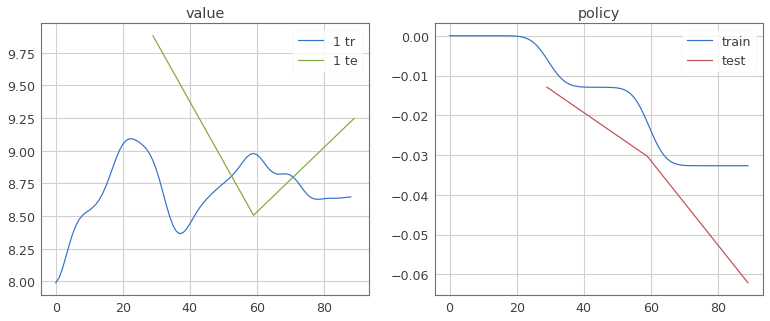

KeyboardInterrupt: 

In [27]:
# --- config ---
plot_every = 30
# --- end ---

for epoch in range(n_epochs):
    epoch_bar.update(1)
    for batch in tqdm(train_dataloader):
        loss = td3_update(step, batch, params)
        
        value1_losses.append(loss[0])
        value2_losses.append(loss[1])
        
        
        if step % params['policy_update'] == 0:
            policy_losses.append(loss[2])
        else:
            policy_losses.append(policy_losses[-1])
        step += 1
        if step % plot_every == 0:
            clear_output(True)
            
            print('step', step)
            #if debug_test_gen_action is not None:
            # recnn.plot.embed_show(debug_test_gen_action[:50])
            # recnn.plot.embed_show(debug_gen_action[:50])
            plot_losses(value1_losses, value2_losses, policy_losses,
                        test=True, smoothing=4)

In [135]:
#torch.save(value_net1.state_dict(), "../../models/td3_value_1.pt")
#torch.save(policy_net.state_dict(), "../../models/td3_policy_1.pt")

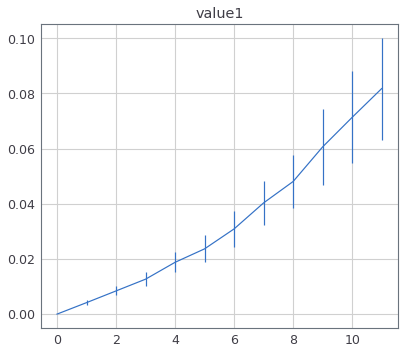

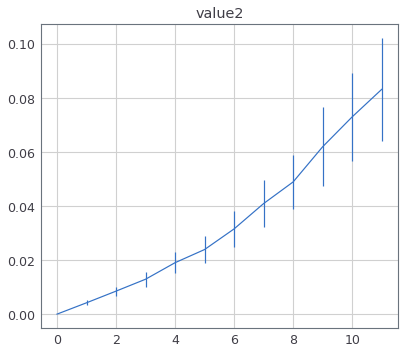

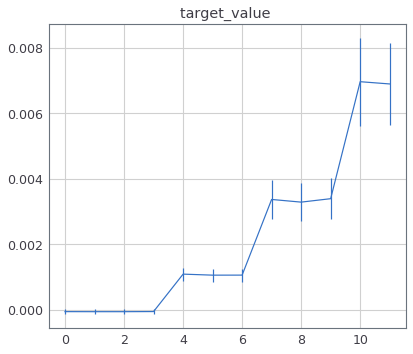

In [28]:
for key, error in debug_dict['error'].items():
    sf = int(np.sqrt(len(error['mean'])))
    plt.errorbar(range(len(error['mean'][::sf])), error['mean'][::sf], error['std'][::sf])
    plt.title(key)
    plt.show()

/home/dev/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


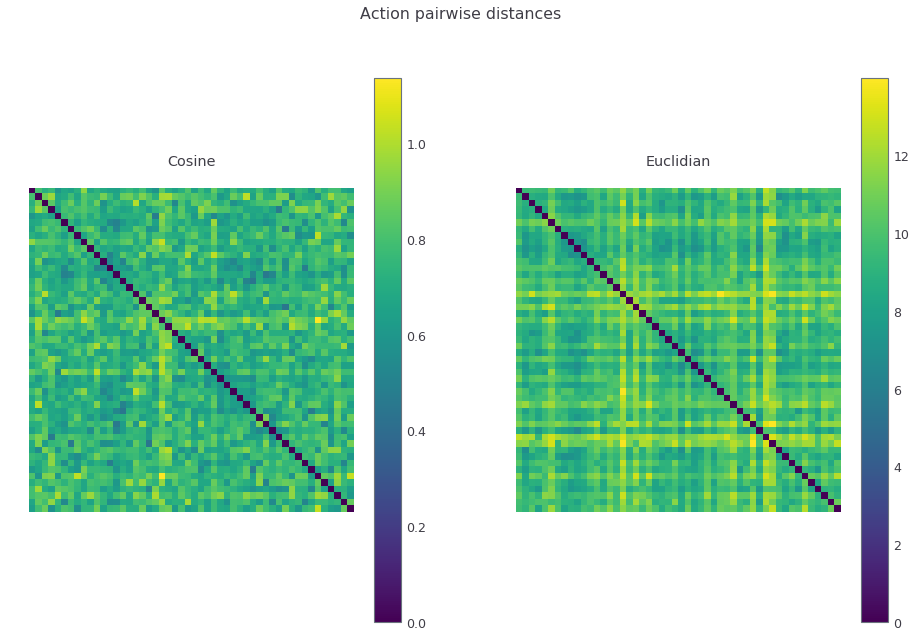

In [29]:
recnn.plot.embed_show(debug_dict['obj']['gen_action'][:50])

/home/dev/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


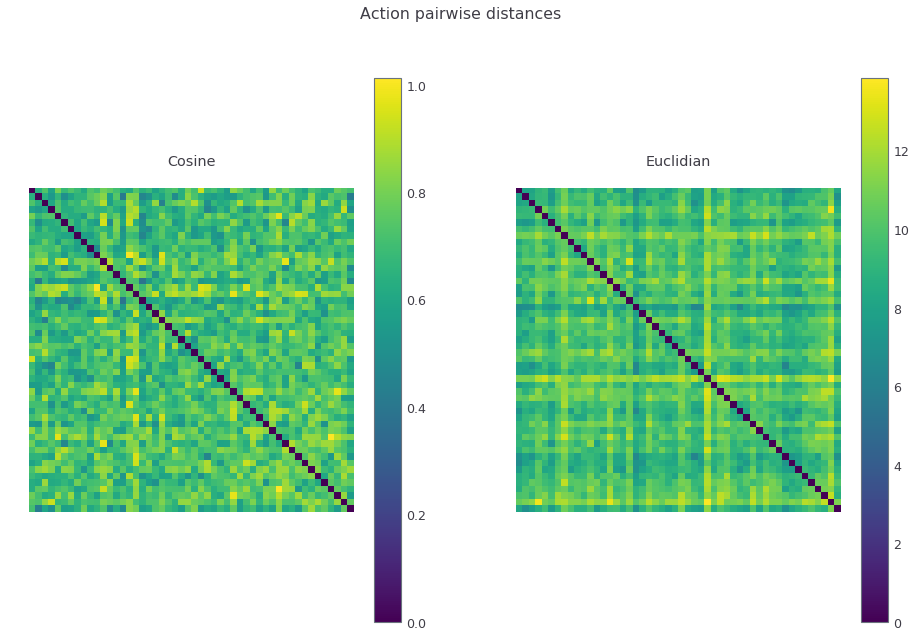

In [30]:
recnn.plot.embed_show(debug_dict['obj']['test gen_action'][:50])

/home/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


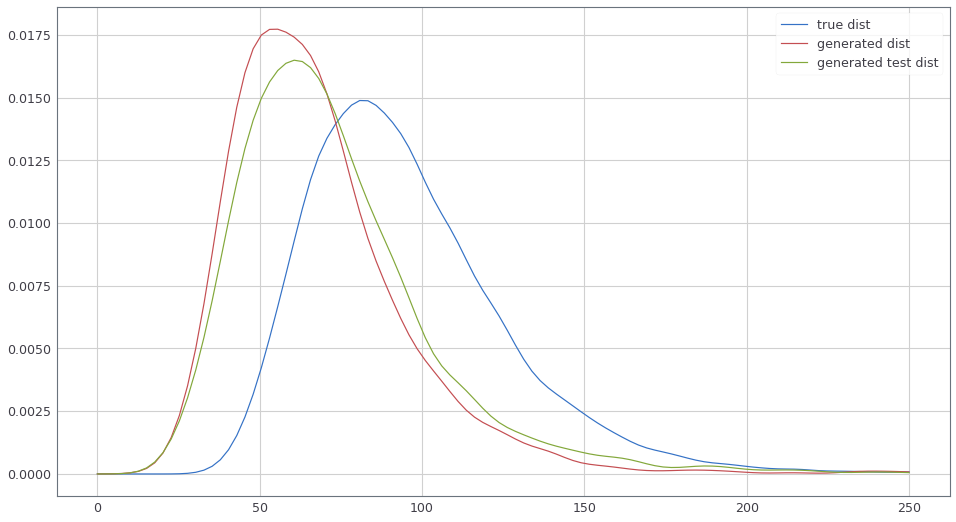

In [32]:
from scipy.special import kl_div
gen_actions = debug_dict['obj']['gen_action']
gen_test_actions = debug_dict['obj']['test gen_action']
true_actions = np.stack([movie_ref[i] for i in movie_ref])



    
ad = recnn.models.AnomalyDetector().to(cuda)
ad.load_state_dict(torch.load('../../models/anomaly.pt'))
ad.eval()

from scipy import stats


true_scores = ad.rec_error(torch.tensor(true_actions).to(cuda).float()).detach().cpu().numpy()
gen_scores = ad.rec_error(torch.tensor(gen_actions).to(cuda).float()).detach().cpu().numpy()
gen_test_scores =ad.rec_error(torch.tensor(gen_test_actions).to(cuda).float()) \
                                                            .detach().cpu().numpy() 

true_kernel = stats.gaussian_kde(true_scores)
gen_kernel = stats.gaussian_kde(gen_scores)
gen_test_kernel = stats.gaussian_kde(gen_test_scores)

x = np.linspace(0,250, 100)
probs_true = true_kernel(x)
probs_gen = gen_kernel(x)
probs_gen_test = gen_test_kernel(x)
plt.figure(figsize=(16, 9))
plt.plot(x, probs_true, '-b', label='true dist')
plt.plot(x, probs_gen, '-r', label='generated dist')
plt.plot(x, probs_gen_test, '-g', label='generated test dist')
plt.legend()
plt.show()